# 🎯 Threshold Calibration for Prompt Output Evaluation

This notebook implements a threshold calibration framework to determine if model outputs are semantically equivalent to expected outputs.

**Models Used:**
- **MiniLM** (`all-MiniLM-L6-v2`) - 384 dimensions, local
- **MPNet** (`all-mpnet-base-v2`) - 768 dimensions, local
- **OpenAI** (`text-embedding-3-large`) - 3072 dimensions, cloud API

**Approach:**
1. Create labeled calibration dataset (good/bad pairs)
2. Compute optimal thresholds using ROC analysis
3. Evaluate outputs using 3-model consensus voting

In [1]:
# Core imports
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from openai import OpenAI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()

# Initialize OpenAI client
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Initialize local models
print("Loading MiniLM model...")
model_minilm = SentenceTransformer('all-MiniLM-L6-v2')

print("Loading MPNet model...")
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

print("All models loaded successfully!")

/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading MiniLM model...
Loading MPNet model...
All models loaded successfully!


## 📊 Calibration Dataset

Define labeled pairs of outputs for calibration:
- **Good pairs**: Semantically equivalent outputs (should PASS)
- **Bad pairs**: Semantically different outputs (should FAIL)

In [2]:
# Good pairs: Semantically equivalent outputs that SHOULD match
good_pairs = [
    # Paraphrased sentences
    ("The capital of France is Paris.", "Paris is the capital city of France."),
    ("Python is a programming language.", "Python is a coding language used by developers."),
    ("Machine learning requires training data.", "ML models need data for training."),
    ("The weather is sunny today.", "Today is a beautiful sunny day."),
    ("I love drinking coffee in the morning.", "Coffee is my favorite morning drink."),
    ("The cat is sleeping on the couch.", "A feline is resting on the sofa."),
    ("Neural networks are used in AI.", "Artificial intelligence uses neural networks."),
    ("The meeting starts at 3 PM.", "The meeting is scheduled to begin at 3 PM."),
    ("She enjoys reading books.", "Reading books is something she loves."),
    ("The restaurant serves Italian food.", "Italian cuisine is served at the restaurant."),
    ("He drives a red car.", "His car is red in color."),
    ("The project deadline is Friday.", "Friday is when the project is due."),
]

# Bad pairs: Semantically different outputs that should NOT match
bad_pairs = [
    # Completely different topics
    ("The capital of France is Paris.", "Machine learning requires large datasets."),
    ("Python is a programming language.", "The weather is sunny today."),
    ("The cat is sleeping on the couch.", "Neural networks use backpropagation."),
    ("I love drinking coffee.", "The stock market closed higher today."),
    ("The meeting starts at 3 PM.", "Elephants are the largest land animals."),
    ("She enjoys reading books.", "The car needs an oil change."),
    # Contradictory statements
    ("The weather is sunny today.", "It's raining heavily outside."),
    ("The project is complete.", "The project hasn't started yet."),
    ("He loves spicy food.", "He can't tolerate any spice."),
    ("The store is open.", "The store is closed for renovation."),
    # Same topic but different meaning
    ("Paris is the capital of France.", "Berlin is the capital of Germany."),
    ("The cat is black.", "The dog is white."),
]

print(f"   Calibration Dataset:")
print(f"   Good pairs (should match): {len(good_pairs)}")
print(f"   Bad pairs (should NOT match): {len(bad_pairs)}")
print(f"   Total pairs: {len(good_pairs) + len(bad_pairs)}")

   Calibration Dataset:
   Good pairs (should match): 12
   Bad pairs (should NOT match): 12
   Total pairs: 24


## 🔧 Similarity Computation Helper

Create a unified function to compute similarity across all 3 models.

In [3]:
def get_similarity(text1: str, text2: str, model_name: str = "minilm") -> float:
    """
    Compute cosine similarity between two texts using specified model.
    
    Args:
        text1: First text
        text2: Second text
        model_name: "minilm", "mpnet", or "openai"
    
    Returns:
        Cosine similarity score between -1 and 1
    """
    if model_name == "openai":
        response = openai_client.embeddings.create(
            model="text-embedding-3-large",
            input=[text1, text2]
        )
        embeddings = np.array([item.embedding for item in response.data])
    else:
        model = model_minilm if model_name == "minilm" else model_mpnet
        embeddings = model.encode([text1, text2])
    
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(similarity)


def get_batch_similarities(pairs: list[tuple[str, str]], model_name: str = "minilm") -> list[float]:
    """
    Compute similarities for a batch of pairs efficiently.
    
    Args:
        pairs: List of (text1, text2) tuples
        model_name: "minilm", "mpnet", or "openai"
    
    Returns:
        List of similarity scores
    """
    if model_name == "openai":
        # Batch all texts for efficiency
        all_texts = []
        for t1, t2 in pairs:
            all_texts.extend([t1, t2])
        
        response = openai_client.embeddings.create(
            model="text-embedding-3-large",
            input=all_texts
        )
        all_embeddings = np.array([item.embedding for item in response.data])
        
        similarities = []
        for i in range(0, len(all_embeddings), 2):
            sim = cosine_similarity([all_embeddings[i]], [all_embeddings[i+1]])[0][0]
            similarities.append(float(sim))
        return similarities
    else:
        model = model_minilm if model_name == "minilm" else model_mpnet
        
        # Encode all texts at once
        all_texts = []
        for t1, t2 in pairs:
            all_texts.extend([t1, t2])
        
        all_embeddings = model.encode(all_texts)
        
        similarities = []
        for i in range(0, len(all_embeddings), 2):
            sim = cosine_similarity([all_embeddings[i]], [all_embeddings[i+1]])[0][0]
            similarities.append(float(sim))
        return similarities


# Test the helper
test_sim = get_similarity(
    "Python is a programming language.",
    "Python is a coding language.",
    model_name="minilm"
)
print(f"Helper function working! Test similarity: {test_sim:.4f}")

Helper function working! Test similarity: 0.9567


## 📈 Compute Similarities for All Pairs

Batch compute similarities for the entire calibration dataset across all 3 models.

In [4]:
# Compute similarities for all models
print("Computing similarities for calibration dataset...")
print("-" * 50)

model_names = ["minilm", "mpnet", "openai"]
all_similarities = {}

for model_name in model_names:
    print(f"  Processing {model_name.upper()}...")
    good_sims = get_batch_similarities(good_pairs, model_name)
    bad_sims = get_batch_similarities(bad_pairs, model_name)
    
    all_similarities[model_name] = {
        "good": good_sims,
        "bad": bad_sims
    }
    
    print(f"    Good pairs: mean={np.mean(good_sims):.3f}, std={np.std(good_sims):.3f}")
    print(f"    Bad pairs:  mean={np.mean(bad_sims):.3f}, std={np.std(bad_sims):.3f}")

print("-" * 50)
print("All similarities computed!")

# Create summary DataFrame
summary_data = []
for model_name in model_names:
    good_sims = all_similarities[model_name]["good"]
    bad_sims = all_similarities[model_name]["bad"]
    summary_data.append({
        "Model": model_name.upper(),
        "Good Mean": f"{np.mean(good_sims):.3f}",
        "Good Std": f"{np.std(good_sims):.3f}",
        "Bad Mean": f"{np.mean(bad_sims):.3f}",
        "Bad Std": f"{np.std(bad_sims):.3f}",
        "Separation": f"{np.mean(good_sims) - np.mean(bad_sims):.3f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nSimilarity Summary:")
print(df_summary.to_string(index=False))

Computing similarities for calibration dataset...
--------------------------------------------------
  Processing MINILM...
    Good pairs: mean=0.857, std=0.108
    Bad pairs:  mean=0.251, std=0.272
  Processing MPNET...
    Good pairs: mean=0.866, std=0.080
    Bad pairs:  mean=0.194, std=0.232
  Processing OPENAI...


/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

    Good pairs: mean=0.816, std=0.057
    Bad pairs:  mean=0.267, std=0.231
--------------------------------------------------
All similarities computed!

Similarity Summary:
 Model Good Mean Good Std Bad Mean Bad Std Separation
MINILM     0.857    0.108    0.251   0.272      0.606
 MPNET     0.866    0.080    0.194   0.232      0.672
OPENAI     0.816    0.057    0.267   0.231      0.549


/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leonardoheis/Source/repo/jargons_test/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

## 🎯 Threshold Calibration

Find optimal thresholds using ROC analysis and F1 optimization.

In [5]:
def calibrate_threshold(good_scores: list[float], bad_scores: list[float]) -> dict:
    """
    Find optimal threshold using ROC and F1 analysis.
    
    Args:
        good_scores: Similarity scores for pairs that should match (label=1)
        bad_scores: Similarity scores for pairs that should NOT match (label=0)
    
    Returns:
        Dictionary with optimal thresholds and statistics
    """
    # Combine scores and create labels
    all_scores = np.array(good_scores + bad_scores)
    all_labels = np.array([1] * len(good_scores) + [0] * len(bad_scores))
    
    # ROC curve analysis
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find ROC-optimal threshold (maximizes Youden's J = TPR - FPR)
    youden_j = tpr - fpr
    roc_optimal_idx = np.argmax(youden_j)
    roc_threshold = roc_thresholds[roc_optimal_idx]
    
    # Precision-Recall curve for F1 optimization
    precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_scores)
    
    # Calculate F1 scores (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_optimal_idx = np.argmax(f1_scores[:-1])  # Last element is sentinel
    f1_threshold = pr_thresholds[f1_optimal_idx]
    
    return {
        "roc_threshold": float(roc_threshold),
        "f1_threshold": float(f1_threshold),
        "roc_auc": float(roc_auc),
        "best_f1": float(f1_scores[f1_optimal_idx]),
        "good_mean": float(np.mean(good_scores)),
        "good_std": float(np.std(good_scores)),
        "bad_mean": float(np.mean(bad_scores)),
        "bad_std": float(np.std(bad_scores)),
        # Store curves for visualization
        "roc_curve": {"fpr": fpr, "tpr": tpr, "thresholds": roc_thresholds},
        "pr_curve": {"precision": precision, "recall": recall, "thresholds": pr_thresholds}
    }


# Calibrate thresholds for each model
print("Calibrating thresholds for each model...")
print("=" * 70)

calibration_results = {}
for model_name in model_names:
    good_sims = all_similarities[model_name]["good"]
    bad_sims = all_similarities[model_name]["bad"]
    
    calibration_results[model_name] = calibrate_threshold(good_sims, bad_sims)
    
    result = calibration_results[model_name]
    print(f"\n{model_name.upper()}:")
    print(f"   ROC-Optimal Threshold: {result['roc_threshold']:.4f}")
    print(f"   F1-Optimal Threshold:  {result['f1_threshold']:.4f}")
    print(f"   ROC AUC Score:         {result['roc_auc']:.4f}")
    print(f"   Best F1 Score:         {result['best_f1']:.4f}")

print("\n" + "=" * 70)

# Create thresholds summary table
thresholds_data = []
for model_name in model_names:
    r = calibration_results[model_name]
    thresholds_data.append({
        "Model": model_name.upper(),
        "ROC Threshold": f"{r['roc_threshold']:.4f}",
        "F1 Threshold": f"{r['f1_threshold']:.4f}",
        "ROC AUC": f"{r['roc_auc']:.4f}",
        "Best F1": f"{r['best_f1']:.4f}"
    })

df_thresholds = pd.DataFrame(thresholds_data)
print("\nCalibrated Thresholds Summary:")
print(df_thresholds.to_string(index=False))

# Store thresholds in a simple dict for evaluation functions
thresholds = {
    model: calibration_results[model]["roc_threshold"]
    for model in model_names
}
print(f"\nUsing ROC-optimal thresholds: {thresholds}")

Calibrating thresholds for each model...

MINILM:
   ROC-Optimal Threshold: 0.7687
   F1-Optimal Threshold:  0.7687
   ROC AUC Score:         0.9792
   Best F1 Score:         0.9565

MPNET:
   ROC-Optimal Threshold: 0.6794
   F1-Optimal Threshold:  0.6794
   ROC AUC Score:         1.0000
   Best F1 Score:         1.0000

OPENAI:
   ROC-Optimal Threshold: 0.7167
   F1-Optimal Threshold:  0.7167
   ROC AUC Score:         1.0000
   Best F1 Score:         1.0000


Calibrated Thresholds Summary:
 Model ROC Threshold F1 Threshold ROC AUC Best F1
MINILM        0.7687       0.7687  0.9792  0.9565
 MPNET        0.6794       0.6794  1.0000  1.0000
OPENAI        0.7167       0.7167  1.0000  1.0000

Using ROC-optimal thresholds: {'minilm': 0.7687277793884277, 'mpnet': 0.6793642044067383, 'openai': 0.716714974510039}


## ✅ Evaluation Functions

Functions to evaluate if model outputs match expected outputs using calibrated thresholds.

In [6]:
def evaluate_output(expected: str, actual: str, thresholds: dict) -> dict:
    """
    Evaluate if actual output matches expected using all 3 models.
    
    Args:
        expected: The expected/reference output
        actual: The actual model output to evaluate
        thresholds: Dict of {model_name: threshold} for each model
    
    Returns:
        Dictionary with results for each model and consensus
    """
    results = {}
    
    for model_name in ["minilm", "mpnet", "openai"]:
        similarity = get_similarity(expected, actual, model_name)
        threshold = thresholds[model_name]
        passed = similarity >= threshold
        
        results[model_name] = {
            "similarity": similarity,
            "threshold": threshold,
            "passed": passed
        }
    
    # Consensus: majority vote (2 out of 3)
    passed_count = sum(1 for r in results.values() if r["passed"])
    results["consensus"] = {
        "passed": passed_count >= 2,
        "votes": f"{passed_count}/3",
        "verdict": "PASS" if passed_count >= 2 else "FAIL"
    }
    
    return results


def evaluate_with_confidence(expected: str, actual: str, thresholds: dict, 
                             margin: float = 0.1) -> dict:
    """
    Evaluate with confidence bands to flag uncertain cases.
    
    Args:
        expected: The expected/reference output
        actual: The actual model output to evaluate
        thresholds: Dict of {model_name: threshold} for each model
        margin: Uncertainty margin around threshold (default 0.1)
    
    Returns:
        Dictionary with results including confidence levels
    """
    results = {}
    
    for model_name in ["minilm", "mpnet", "openai"]:
        similarity = get_similarity(expected, actual, model_name)
        threshold = thresholds[model_name]
        
        # Determine confidence level
        if similarity >= threshold + margin:
            verdict = "HIGH_PASS"
            confidence = "high"
        elif similarity >= threshold:
            verdict = "PASS"
            confidence = "medium"
        elif similarity >= threshold - margin:
            verdict = "UNCERTAIN"
            confidence = "low"
        else:
            verdict = "FAIL"
            confidence = "high"
        
        results[model_name] = {
            "similarity": similarity,
            "threshold": threshold,
            "verdict": verdict,
            "confidence": confidence
        }
    
    # Determine overall verdict
    verdicts = [r["verdict"] for r in results.values() if r["verdict"] != "consensus"]
    
    high_pass_count = sum(1 for v in verdicts if v == "HIGH_PASS")
    pass_count = sum(1 for v in verdicts if v in ["HIGH_PASS", "PASS"])
    uncertain_count = sum(1 for v in verdicts if v == "UNCERTAIN")
    fail_count = sum(1 for v in verdicts if v == "FAIL")
    
    if high_pass_count >= 2 or pass_count == 3:
        overall_verdict = "HIGH CONFIDENCE PASS"
    elif pass_count >= 2:
        overall_verdict = "PASS"
    elif fail_count >= 2:
        overall_verdict = "FAIL"
    elif uncertain_count > 0:
        overall_verdict = "UNCERTAIN - Manual review recommended"
    else:
        overall_verdict = "FAIL"
    
    results["overall"] = {
        "verdict": overall_verdict,
        "pass_votes": f"{pass_count}/3",
        "uncertain_count": uncertain_count
    }
    
    return results


def print_evaluation_result(expected: str, actual: str, result: dict, with_confidence: bool = False):
    """Pretty print evaluation results."""
    print(f"\n{'='*70}")
    print(f"Expected: {expected[:60]}{'...' if len(expected) > 60 else ''}")
    print(f"Actual:   {actual[:60]}{'...' if len(actual) > 60 else ''}")
    print(f"{'─'*70}")
    
    for model_name in ["minilm", "mpnet", "openai"]:
        r = result[model_name]
        sim = r["similarity"]
        thresh = r["threshold"]
        
        if with_confidence:
            verdict = r["verdict"]
            if verdict == "HIGH_PASS":
                status = "HIGH PASS"
            elif verdict == "PASS":
                status = "PASS"
            elif verdict == "UNCERTAIN":
                status = "UNCERTAIN"
            else:
                status = "FAIL"
        else:
            status = "PASS" if r["passed"] else "FAIL"
        
        print(f"   {model_name.upper():8} | Sim: {sim:.4f} | Thresh: {thresh:.4f} | {status}")
    
    print(f"{'─'*70}")
    if with_confidence:
        print(f"   OVERALL: {result['overall']['verdict']}")
    else:
        print(f"   CONSENSUS: {result['consensus']['verdict']} ({result['consensus']['votes']} models passed)")
    print(f"{'='*70}")

## 📊 Visualization

Visualize the similarity distributions and calibrated thresholds.

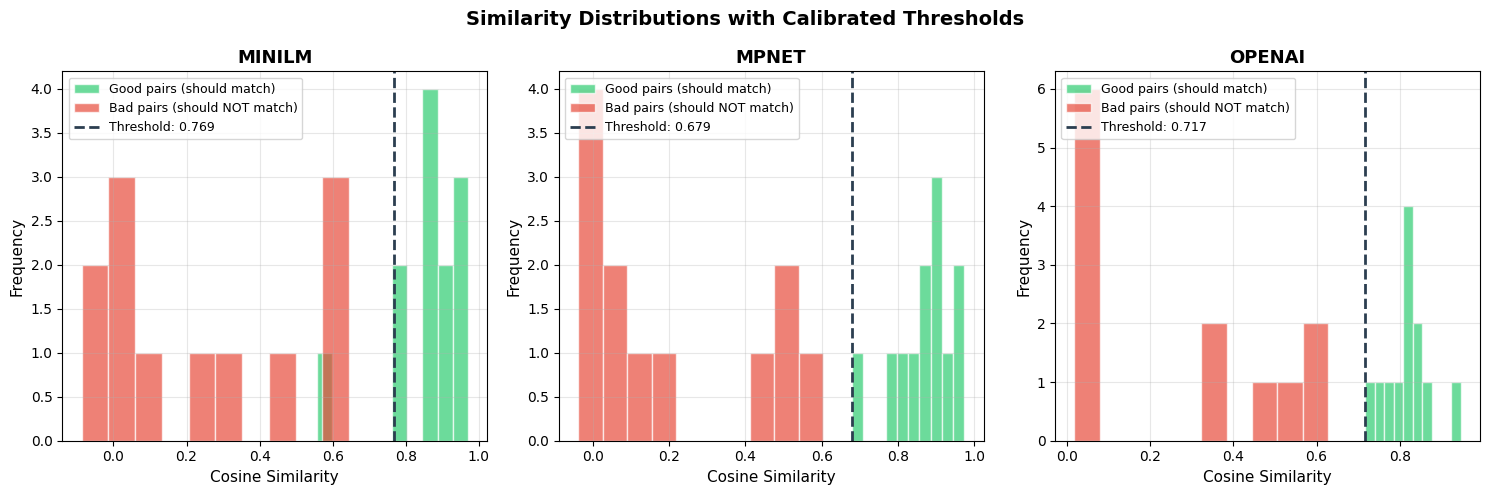

In [7]:
# Create visualization of similarity distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {"minilm": "#2ecc71", "mpnet": "#3498db", "openai": "#9b59b6"}

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    good_sims = all_similarities[model_name]["good"]
    bad_sims = all_similarities[model_name]["bad"]
    threshold = thresholds[model_name]
    
    # Plot histograms
    ax.hist(good_sims, bins=10, alpha=0.7, label="Good pairs (should match)", 
            color="#2ecc71", edgecolor="white")
    ax.hist(bad_sims, bins=10, alpha=0.7, label="Bad pairs (should NOT match)", 
            color="#e74c3c", edgecolor="white")
    
    # Plot threshold line
    ax.axvline(x=threshold, color="#2c3e50", linestyle="--", linewidth=2, 
               label=f"Threshold: {threshold:.3f}")
    
    ax.set_xlabel("Cosine Similarity", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.set_title(f"{model_name.upper()}", fontsize=13, fontweight="bold")
    ax.legend(loc="upper left", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Similarity Distributions with Calibrated Thresholds", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 🧪 Interactive Testing

Test the evaluation framework with example cases.

In [11]:
# Test Case 1: Clear PASS - Semantically equivalent
print("TEST CASE 1: Clear PASS (semantically equivalent)")
expected1 = "Machine learning models require training data to learn patterns."
actual1 = "ML algorithms need datasets for training to identify patterns."

result1 = evaluate_output(expected1, actual1, thresholds)
print_evaluation_result(expected1, actual1, result1)

TEST CASE 1: Clear PASS (semantically equivalent)

Expected: Machine learning models require training data to learn patte...
Actual:   ML algorithms need datasets for training to identify pattern...
──────────────────────────────────────────────────────────────────────
   MINILM   | Sim: 0.7756 | Thresh: 0.7687 | PASS
   MPNET    | Sim: 0.8304 | Thresh: 0.6794 | PASS
   OPENAI   | Sim: 0.7966 | Thresh: 0.7167 | PASS
──────────────────────────────────────────────────────────────────────
   CONSENSUS: PASS (3/3 models passed)


In [12]:
# Test Case 2: Clear FAIL - Completely different topics
print("TEST CASE 2: Clear FAIL (completely different)")
expected2 = "The capital of France is Paris."
actual2 = "Neural networks use backpropagation for training."

result2 = evaluate_output(expected2, actual2, thresholds)
print_evaluation_result(expected2, actual2, result2)

TEST CASE 2: Clear FAIL (completely different)

Expected: The capital of France is Paris.
Actual:   Neural networks use backpropagation for training.
──────────────────────────────────────────────────────────────────────
   MINILM   | Sim: 0.0653 | Thresh: 0.7687 | FAIL
   MPNET    | Sim: 0.0510 | Thresh: 0.6794 | FAIL
   OPENAI   | Sim: 0.0710 | Thresh: 0.7167 | FAIL
──────────────────────────────────────────────────────────────────────
   CONSENSUS: FAIL (0/3 models passed)


In [13]:
# Test Case 3: Borderline case - Use confidence evaluation
print("TEST CASE 3: Borderline case (with confidence)")
expected3 = "Python is widely used in data science."
actual3 = "Data analysis often uses programming languages."

result3 = evaluate_with_confidence(expected3, actual3, thresholds)
print_evaluation_result(expected3, actual3, result3, with_confidence=True)

TEST CASE 3: Borderline case (with confidence)

Expected: Python is widely used in data science.
Actual:   Data analysis often uses programming languages.
──────────────────────────────────────────────────────────────────────
   MINILM   | Sim: 0.6990 | Thresh: 0.7687 | UNCERTAIN
   MPNET    | Sim: 0.7085 | Thresh: 0.6794 | PASS
   OPENAI   | Sim: 0.4943 | Thresh: 0.7167 | FAIL
──────────────────────────────────────────────────────────────────────
   OVERALL: UNCERTAIN - Manual review recommended


In [14]:
# Test Case 4: Same topic, contradictory - Should FAIL
print("TEST CASE 4: Same topic but contradictory")
expected4 = "The weather is sunny and warm today."
actual4 = "It's cold and raining outside."

result4 = evaluate_with_confidence(expected4, actual4, thresholds)
print_evaluation_result(expected4, actual4, result4, with_confidence=True)

TEST CASE 4: Same topic but contradictory

Expected: The weather is sunny and warm today.
Actual:   It's cold and raining outside.
──────────────────────────────────────────────────────────────────────
   MINILM   | Sim: 0.5826 | Thresh: 0.7687 | FAIL
   MPNET    | Sim: 0.2342 | Thresh: 0.6794 | FAIL
   OPENAI   | Sim: 0.3921 | Thresh: 0.7167 | FAIL
──────────────────────────────────────────────────────────────────────
   OVERALL: FAIL


In [15]:
# Interactive: Test your own inputs!
print("TRY YOUR OWN INPUTS")
print("=" * 70)

# Modify these to test your own cases
your_expected = "The restaurant serves delicious Italian pasta."
your_actual = "They make great Italian food at this place."

print(f"\nYour expected: {your_expected}")
print(f"Your actual:   {your_actual}")

your_result = evaluate_with_confidence(your_expected, your_actual, thresholds)
print_evaluation_result(your_expected, your_actual, your_result, with_confidence=True)

TRY YOUR OWN INPUTS

Your expected: The restaurant serves delicious Italian pasta.
Your actual:   They make great Italian food at this place.

Expected: The restaurant serves delicious Italian pasta.
Actual:   They make great Italian food at this place.
──────────────────────────────────────────────────────────────────────
   MINILM   | Sim: 0.7335 | Thresh: 0.7687 | UNCERTAIN
   MPNET    | Sim: 0.7046 | Thresh: 0.6794 | PASS
   OPENAI   | Sim: 0.6782 | Thresh: 0.7167 | UNCERTAIN
──────────────────────────────────────────────────────────────────────
   OVERALL: UNCERTAIN - Manual review recommended


## 📋 Summary

This notebook provides:

1. **Calibration Dataset**: Labeled good/bad pairs for threshold training
2. **Optimal Thresholds**: Computed using ROC analysis for each model
3. **Evaluation Functions**:
   - `evaluate_output()` - Basic pass/fail with 3-model consensus
   - `evaluate_with_confidence()` - Adds uncertainty zones for borderline cases
4. **Visualizations**: Distribution histograms and ROC curves

**Usage:**
```python
# Basic evaluation
result = evaluate_output(expected, actual, thresholds)

# With confidence bands
result = evaluate_with_confidence(expected, actual, thresholds)
```

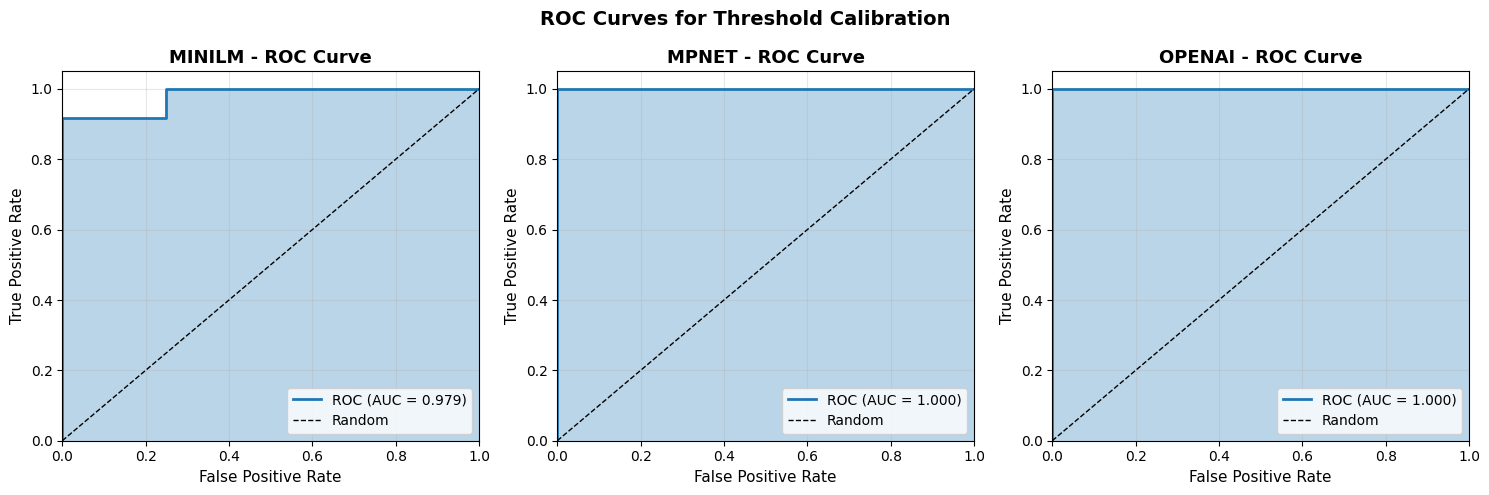

In [16]:
# Plot ROC curves for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    roc_data = calibration_results[model_name]["roc_curve"]
    fpr = roc_data["fpr"]
    tpr = roc_data["tpr"]
    roc_auc = calibration_results[model_name]["roc_auc"]
    
    ax.plot(fpr, tpr, linewidth=2, label=f"ROC (AUC = {roc_auc:.3f})")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
    ax.fill_between(fpr, tpr, alpha=0.3)
    
    ax.set_xlabel("False Positive Rate", fontsize=11)
    ax.set_ylabel("True Positive Rate", fontsize=11)
    ax.set_title(f"{model_name.upper()} - ROC Curve", fontsize=13, fontweight="bold")
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.suptitle("ROC Curves for Threshold Calibration", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()